Import the library

In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Load the dataset

In [413]:
data = pd.read_csv('data-2.csv')

# Data Preprocessing

In [414]:
data.head()


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [415]:
 # Drop non-numeric column
data = data.drop(columns=['country']) 

In [416]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [418]:
data.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [419]:
# Normalize the data using min-max scaling
data_standardized = (data - data.mean()) / data.std()

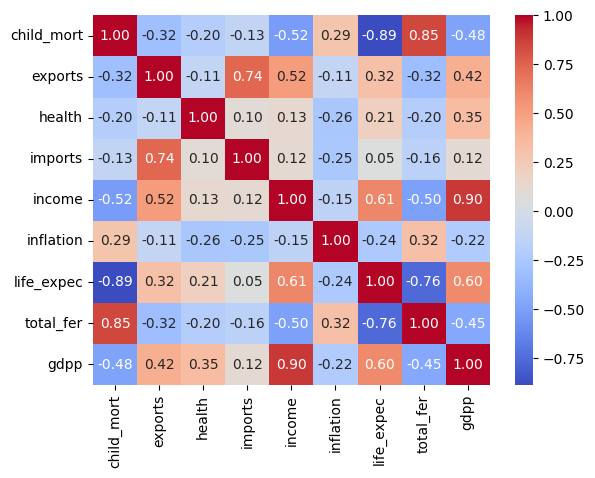

In [420]:
data_corr = data_standardized.corr()
sns.heatmap(data_corr, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
plt.show()

In [421]:
data_standardized = data_standardized.drop(columns=['income']) 

<Axes: xlabel='child_mort', ylabel='gdpp'>

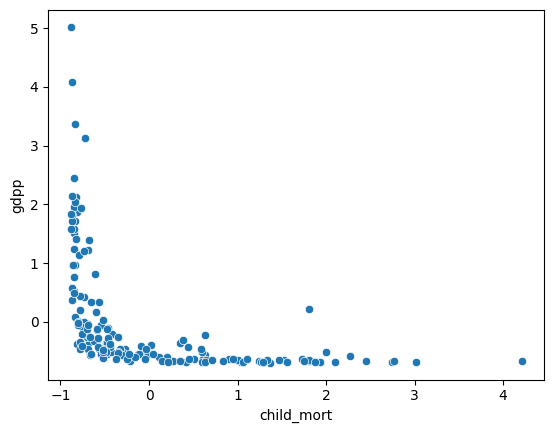

In [422]:

sns.scatterplot(data = data_standardized, x = 'child_mort', y = 'gdpp')

# K-Mean

In [423]:
def kmeans(data, k, max_iters=100, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    # Step 1: Randomly initialize centroids
    centroids = data.sample(n=k, random_state=random_state).values  # Randomly sample k data points as centroids

    for _ in range(max_iters):
        # Step 2: Assign each data point to the nearest centroid
        distances = np.linalg.norm(data.values[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 3: Recalculate centroids as the mean of assigned points
        new_centroids = np.array([data.values[labels == i].mean(axis=0) for i in range(k)])

        # Step 4: Check for convergence (if centroids do not change)
        if np.allclose(centroids, new_centroids, atol=1e-6):  # Use a small tolerance for floating-point comparisons
            break

        centroids = new_centroids
    
    return labels, centroids

# Apply KMeans
k = 2
# Number of clusters
labels_kmeans, centroids_kmeans = kmeans(data_standardized, k, random_state=42)

# Add the cluster labels to the original data
data_clustered = pd.concat(
    [data_standardized, pd.DataFrame(labels_kmeans, columns=['cluster'], index=data_standardized.index)],
    axis=1
)

# Output clustered data and centroids
print(data_clustered.head())



   child_mort   exports    health   imports  inflation  life_expec  total_fer  \
0    1.287660 -1.134867  0.278251 -0.082208   0.156864   -1.614237   1.897176   
1   -0.537333 -0.478220 -0.096725  0.070624  -0.311411    0.645924  -0.857394   
2   -0.272015 -0.098824 -0.963176 -0.639838   0.786908    0.668413  -0.038289   
3    2.001787  0.773056 -1.443729 -0.164820   1.382894   -1.175698   2.121770   
4   -0.693548  0.160186 -0.286034  0.496076  -0.599944    0.702147  -0.540321   

       gdpp  cluster  
0 -0.677143        1  
1 -0.484167        0  
2 -0.463980        0  
3 -0.514720        1  
4 -0.041692        0  


Elbow method

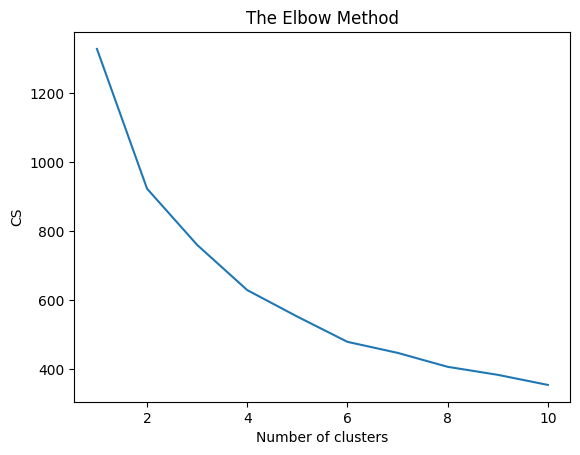

In [424]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(data_standardized )
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Visualiation

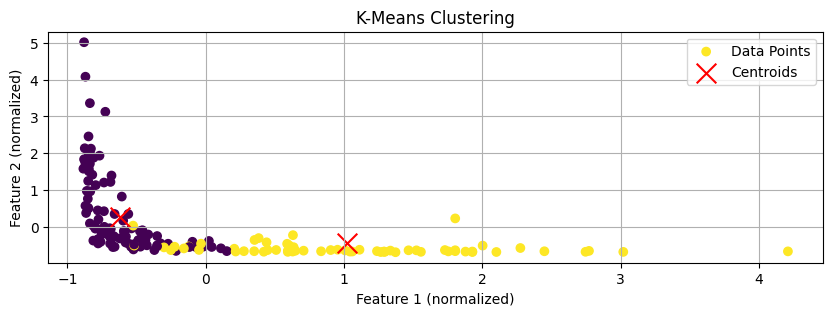

In [425]:
def plot_kmeans(data, labels, centroids):
    plt.figure(figsize=(10, 3))
    
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis', marker='o', label='Data Points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
    
    plt.title('K-Means Clustering')
    plt.xlabel('Feature 1 (normalized)')
    plt.ylabel('Feature 2 (normalized)')
    plt.legend()
    plt.grid()
    plt.show()

plot_kmeans(data_standardized[['child_mort', 'gdpp']], labels_kmeans, centroids_kmeans)


# KNN

Train Accuracy: 0.9658119658119658
Test Accuracy: 0.94


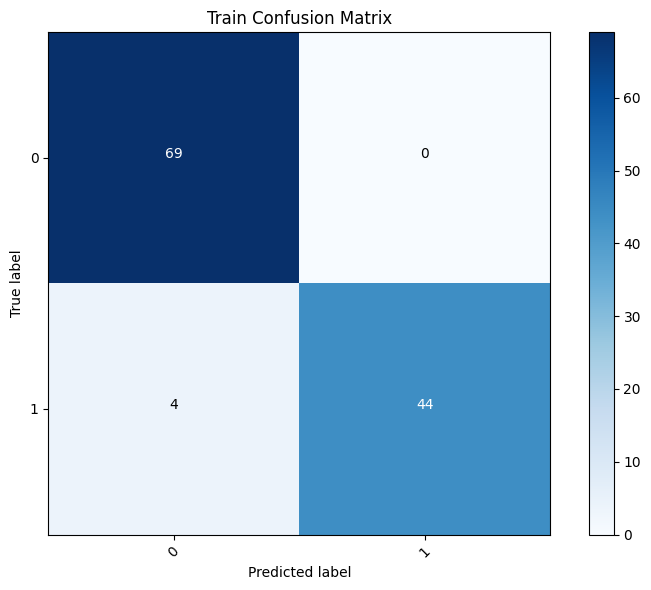

In [426]:
# Step 1: Split dataset into train and test sets
def train_test_split_pandas(data, test_size=0.3, random_state=None):
    if random_state:
        np.random.seed(random_state)
    shuffled_indices = np.random.permutation(data.index)
    test_size = int(len(data) * test_size)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.loc[train_indices], data.loc[test_indices]

train_data, test_data = train_test_split_pandas(data_clustered, test_size=0.3, random_state=42)

# Step 2: Separate features and labels
X_train = train_data.drop(columns=['cluster']).values
y_train = train_data['cluster'].values
X_test = test_data.drop(columns=['cluster']).values
y_test = test_data['cluster'].values

# Step 3: Implement k-NN
def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test:
        distances = np.linalg.norm(X_train - test_point, axis=1)  # Compute distances
        nearest_indices = np.argsort(distances)[:k]              # Find k nearest neighbors
        nearest_labels = y_train[nearest_indices]               # Get their labels
        most_common = np.bincount(nearest_labels).argmax()      # Majority vote
        predictions.append(most_common)
    return np.array(predictions)

# Predict labels for both train and test data
k = 2
y_train_pred = knn_predict(X_train, y_train, X_train, k=k)
y_test_pred = knn_predict(X_train, y_train, X_test, k=k)

# Step 4: Evaluate performance
def accuracy_score_numpy(y_true, y_pred):
    return np.mean(y_true == y_pred)

train_accuracy = accuracy_score_numpy(y_train, y_train_pred)
test_accuracy = accuracy_score_numpy(y_test, y_test_pred)

# Confusion matrix
def confusion_matrix_numpy(y_true, y_pred, n_classes):
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        conf_matrix[true_label, pred_label] += 1
    return conf_matrix

n_classes = len(np.unique(y_train))
train_conf_matrix = confusion_matrix_numpy(y_train, y_train_pred, n_classes)
test_conf_matrix = confusion_matrix_numpy(y_test, y_test_pred, n_classes)

# Visualize Confusion Matrices
def plot_confusion_matrix(conf_matrix, title, class_labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", 
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Outputs
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
plot_confusion_matrix(train_conf_matrix, "Train Confusion Matrix", class_labels=range(n_classes))

# Hierarchical clustering

In [427]:
# Hierarchical clustering function (modified to stop at 3 clusters)
def hierarchical_clustering(data, k=3):
    # Calculate distance matrix
    data_values = data_standardized.values

    # Calculate pairwise Euclidean distances
    distance_matrix = np.linalg.norm(data_values[:, np.newaxis] - data_values, axis=2)
    
    # Create clusters initially as individual points
    clusters = [[i] for i in range(len(data))]
    
    # Perform agglomerative clustering
    while len(clusters) > k:
        min_distance = np.inf
        to_merge = (0, 1)
        
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = distance_matrix[clusters[i], :][:, clusters[j]].min()
                if dist < min_distance:
                    min_distance = dist
                    to_merge = (i, j)

        # Merge the closest clusters
        merged_cluster = clusters[to_merge[0]] + clusters[to_merge[1]]
        clusters.append(merged_cluster)
        
        # Remove merged clusters from list
        clusters.pop(max(to_merge))
        clusters.pop(min(to_merge))

    return clusters  # Return the final clusters (now 3 clusters)

# Perform Hierarchical Clustering to get 3 clusters
k = 3  # Number of clusters
final_clusters_hierarchical = hierarchical_clustering(data_standardized, k)

# Create an array to hold the cluster labels
cluster_labels = np.zeros(len(data_standardized), dtype=int)

# Assign labels to each data point based on the final clusters
for cluster_idx, cluster in enumerate(final_clusters_hierarchical):
    for point_idx in cluster:
        cluster_labels[point_idx] = cluster_idx

# Add the cluster labels to the original data
data_clustered_2 = data_standardized.copy()
data_clustered_2['cluster'] = cluster_labels

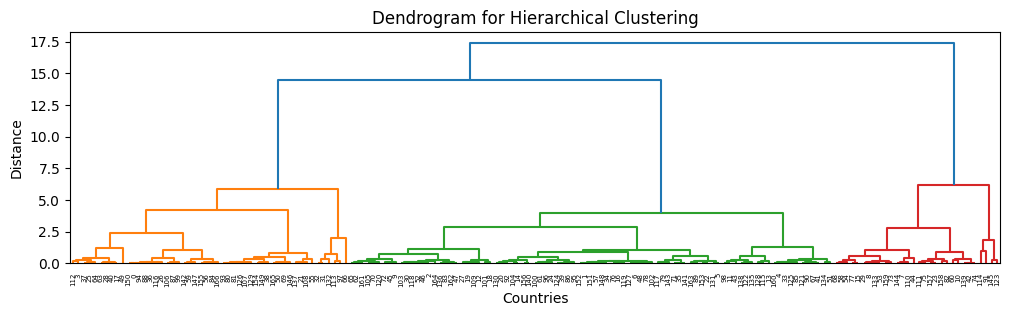

In [428]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(data):
    linked = linkage(data.values, 'ward')
    
    plt.figure(figsize=(12, 3))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    
    plt.title('Dendrogram for Hierarchical Clustering')
    plt.xlabel('Countries')
    plt.ylabel('Distance')
    plt.show()

# Plot Dendrogram for Hierarchical Clustering
plot_dendrogram(data_standardized[['child_mort', 'gdpp']])


# Metric

In [ ]:
# Function to calculate the Euclidean distance between two points
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

# Function to calculate the silhouette score
def silhouette_score(data, labels):
    n_samples = len(data)
    score = 0.0

    # Create a distance matrix
    distance_matrix = np.zeros((n_samples, n_samples))
    
    # Calculate pairwise distances (Euclidean distance)
    for i in range(n_samples):
        for j in range(n_samples):
            if i != j:
                distance_matrix[i, j] = euclidean_distance(data.iloc[i], data.iloc[j])

    # Calculate silhouette score for each sample
    for i in range(n_samples):
        same_cluster_points = np.where(labels == labels[i])[0]
        same_cluster_points = same_cluster_points[same_cluster_points != i]  # Exclude self

        # Intra-cluster distance a(i)
        a_i = np.mean(distance_matrix[i, same_cluster_points]) if len(same_cluster_points) > 0 else 0

        # Inter-cluster distances b(i)
        b_i = np.inf
        for label in np.unique(labels):
            if label != labels[i]:
                other_cluster_points = np.where(labels == label)[0]
                b_i_cluster = np.mean(distance_matrix[i, other_cluster_points])
                b_i = min(b_i, b_i_cluster)

        # Silhouette score for point i
        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
        score += s_i

    return score / n_samples

labels_hierarchical = data_clustered_2['cluster'].values

# Calculate silhouette score for Hierarchical Clustering
silhouette_hierarchical = silhouette_score(data_standardized, labels_hierarchical)
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}")

# Calculate silhouette score for KMeans
silhouette_kmeans = silhouette_score(data_standardized, labels_kmeans)
print(f"Silhouette Score for KMeans: {silhouette_kmeans}")

Silhouette Score for Hierarchical Clustering: 0.580324487751061
Silhouette Score for KMeans: 0.30048909707376503
